In [2]:

from scipy.stats import norm

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pl.bucket_data import get_borough,bucket_by_time
from pl.rush_off_bound import rush_off_bound
from pl.distribution_check import poisson_check,nb_check

In [21]:
DATA_DIR = '202401-citibike-tripdata_2.csv'
DATA_DIR_2  = '202401-citibike-tripdata_1.csv'
data = pl.read_csv(DATA_DIR,ignore_errors=True)
data2 = pl.read_csv(DATA_DIR_2,ignore_errors=True)
data = data.vstack(data2)
print(data.sort('started_at'))

shape: (1_888_085, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ride_id   ┆ rideable_ ┆ started_a ┆ ended_at  ┆ … ┆ start_lng ┆ end_lat   ┆ end_lng   ┆ member_c │
│ ---       ┆ type      ┆ t         ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ asual    │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆ str       ┆ str       ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 5594D8DDA ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98765 ┆ null      ┆ null      ┆ casual   │
│ 68F5BB9   ┆ ike       ┆ 1 02:36:5 ┆ 1 03:36:4 ┆   ┆ 4         ┆           ┆           ┆          │
│           ┆           ┆ 5.648     ┆ 8.341     ┆   ┆           ┆           ┆           ┆          │
│ 36D094894 ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98770 ┆ nu

In [22]:

data = data.with_columns(
    pl.col("started_at").str.to_datetime(strict=False),
    pl.col("ended_at").str.to_datetime(strict=False)
)
data = data.with_columns(
    pl.col("started_at").dt.date().alias("start_date"),
    pl.col("started_at").dt.time().alias("start_time"),
    pl.col("ended_at").dt.date().alias("end_date"),
    pl.col("ended_at").dt.time().alias("end_time"),
)
data = data.with_columns(
    (pl.col("ended_at")- pl.col("started_at")).alias("trip_time")
)
data = data.with_columns(
    pl.struct(['start_lat', 'start_lng'])
    .map_elements(
        lambda x: get_borough(x['start_lat'], x['start_lng']),
        return_dtype=pl.Utf8
    )
    .alias('start_borough')
)
data = data.with_columns(
    pl.struct(['end_lat', 'end_lng'])
    .map_elements(
        lambda x: get_borough(x['end_lat'], x['end_lng']),
        return_dtype=pl.Utf8
    )
    .alias('end_borough')
)


counts = data['end_borough'].value_counts()
print(counts)
print(data.head(0))


shape: (4, 2)
┌─────────────┬─────────┐
│ end_borough ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ Brooklyn    ┆ 323024  │
│ Manhattan   ┆ 1500095 │
│ Unknown     ┆ 5578    │
│ Bronx       ┆ 59388   │
└─────────────┴─────────┘
shape: (0, 20)
┌─────────┬────────────┬────────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ ride_id ┆ rideable_t ┆ started_at ┆ ended_at  ┆ … ┆ end_time ┆ trip_time ┆ start_bor ┆ end_borou │
│ ---     ┆ ype        ┆ ---        ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ough      ┆ gh        │
│ str     ┆ ---        ┆ datetime[μ ┆ datetime[ ┆   ┆ time     ┆ duration[ ┆ ---       ┆ ---       │
│         ┆ str        ┆ s]         ┆ μs]       ┆   ┆          ┆ μs]       ┆ str       ┆ str       │
╞═════════╪════════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
└─────────┴────────────┴────────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘


In [23]:
multi_zone_1h_a = bucket_by_time(data, group_col=['end_station_name'], condition='arrival', freq='1h')
multi_zone_1h_d = bucket_by_time(data, group_col=['start_station_name'], condition='departure', freq='1h')

# Rush Hours data modelling (Top 30%)
## Arrivals and Departures from stations
### Data aggregated over all the stations

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 6    ┆ 38804     │
│ 14   ┆ 117160    │
│ 21   ┆ 61393     │
│ 18   ┆ 156627    │
│ 19   ┆ 116730    │
│ …    ┆ …         │
│ 0    ┆ 22652     │
│ 15   ┆ 129658    │
│ 23   ┆ 34301     │
│ 11   ┆ 89760     │
│ 5    ┆ 13872     │
└──────┴───────────┘
{'total_sum': [14, 18, 17, 9, 16, 8, 15]}
shape: (217, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-02 08:00:00 ┆ 5072      ┆ 2024-01-02 ┆ 08:00:00 ┆ 8    │
│ 2024-01-31 08:00:00 ┆ 7490      ┆ 2024-01-31 ┆ 08:00:00 ┆ 8    │
│ 2024-01-10 08:00:00 ┆ 7404      ┆ 2024-01-10 ┆ 08:00:00 ┆ 8    │
│ 2024-01-19 08:00:00 ┆ 4473      

/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_6354/3868390333.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted_cs_a = city_sum_reordered_a.pivot(


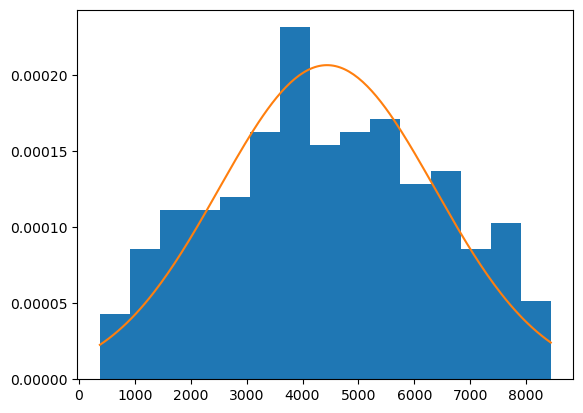

In [54]:
#arrivals
city_sum_1h_a = multi_zone_1h_a.select(pl.col('event_time_bucket'),
                                   pl.sum_horizontal(pl.all().exclude('event_time_bucket')).alias('total_sum'))
city_sum_reordered_a = city_sum_1h_a.with_columns(pl.col('event_time_bucket').dt.date().alias('date'),
                                              pl.col('event_time_bucket').dt.time().alias('time'),)
columns = ['date']
pivoted_cs_a = city_sum_reordered_a.pivot(
    values='total_sum',
    columns = columns,
    aggregate_function='sum',
    index = 'time'
)
pivoted_cs_sum_a = pivoted_cs_a.select(pl.col('time').alias('event_time_bucket'),
                                     pl.sum_horizontal(pl.all().exclude('time').alias('total_sum')))
# print(pivoted_cs_sum)

peak_hours_a = rush_off_bound(pivoted_cs_sum_a,
                            threshold = 0.70,
                            condition= 'hour',
                            check_var = 'rush',
                            bound = 'markov',
                            dist_var = 'none')
print(peak_hours_a)
city_sum_reordered_a = city_sum_reordered_a.with_columns(pl.col('event_time_bucket').dt.hour().alias('hour'))
city_top30_a = city_sum_reordered_a.filter(pl.col('hour').is_in(peak_hours_a['total_sum'])).sort('hour')

print(city_top30_a)
print(city_top30_a['total_sum'].to_list())
data_l1_a = np.array(city_top30_a['total_sum'].to_list())
data_l1_mean_a = np.mean(data_l1_a)
data_l1_std_a = np.std(data_l1_a)
print(data_l1_mean_a)
print(data_l1_std_a**2)

plt.hist(data_l1_a, bins=15, density=True)
xs_a = np.linspace(min(data_l1_a), max(data_l1_a), 200)
plt.plot(xs_a, norm.pdf(xs_a, loc=data_l1_mean_a, scale=data_l1_std_a))


Final Bin values: 42


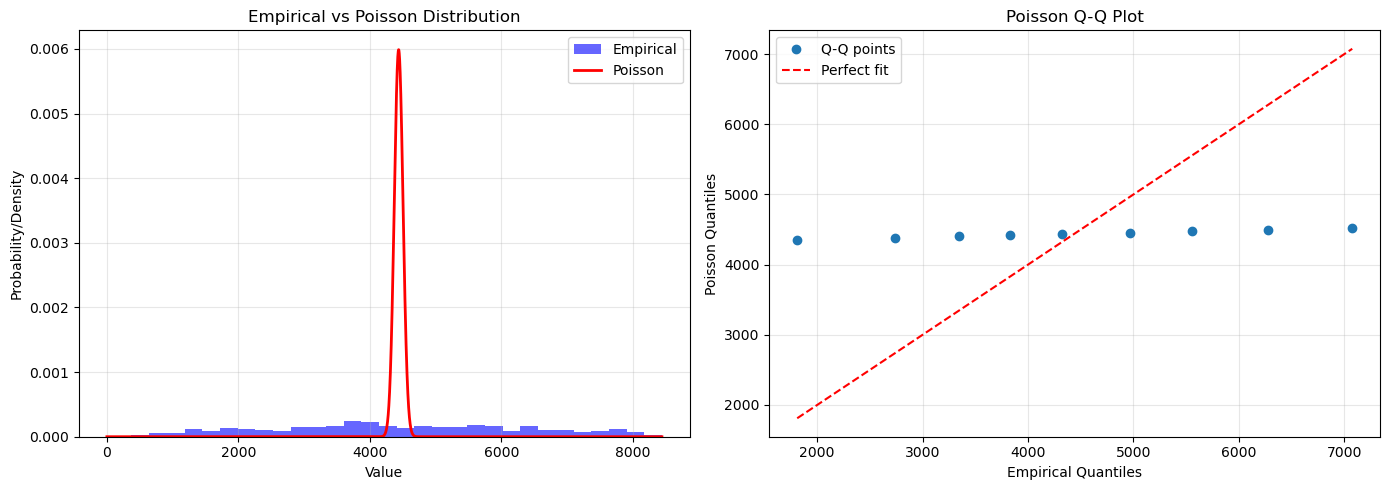

{'chi_score': np.float64(2.065375522783223e+293), 'dispersion': np.float64(845.5361053532827), 'emp_quantile': array([1810.6, 2739. , 3344. , 3829.4, 4325. , 4971.6, 5556.2, 6277.4,
       7076.6]), 'poisson_quantile': [np.float64(4353.0), np.float64(4382.0), np.float64(4403.0), np.float64(4421.0), np.float64(4438.0), np.float64(4455.0), np.float64(4473.0), np.float64(4494.0), np.float64(4524.0)], 'p_value': np.float64(0.0)}


In [55]:
poi_dict_a = poisson_check(data_l1_a)
print(poi_dict_a)

Final Bin values (NB): 42


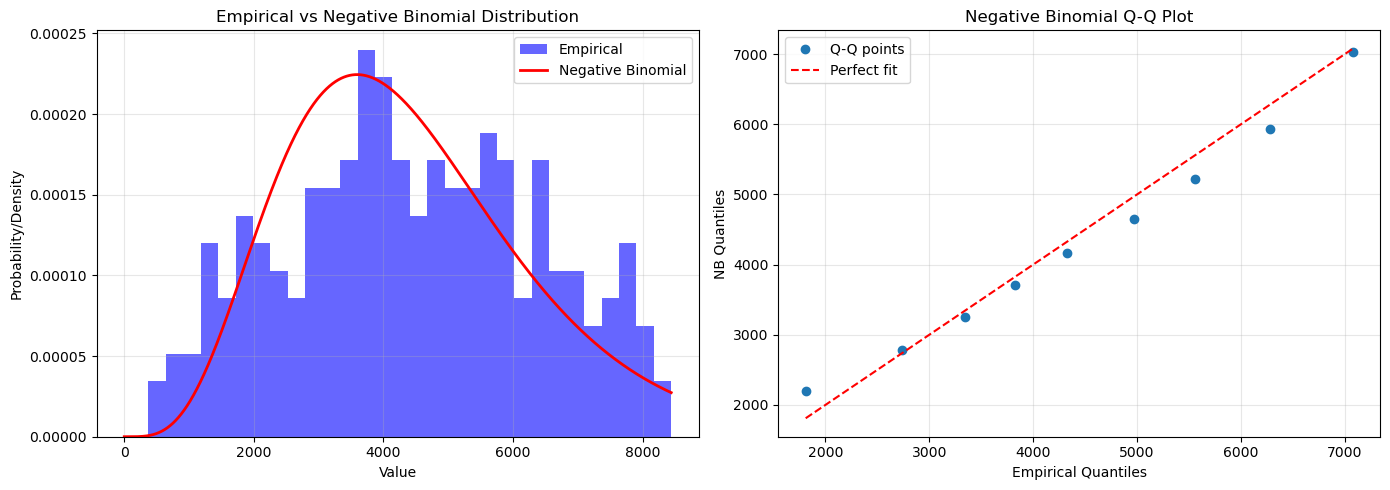

{'chi_score': np.float64(91.70088377844326), 'dispersion': np.float64(845.5361053532827), 'emp_quantile': array([1810.6, 2739. , 3344. , 3829.4, 4325. , 4971.6, 5556.2, 6277.4,
       7076.6]), 'nb_quantile': [np.float64(2206.0), np.float64(2782.0), np.float64(3258.0), np.float64(3705.0), np.float64(4160.0), np.float64(4651.0), np.float64(5216.0), np.float64(5934.0), np.float64(7031.0)], 'n_param': np.float64(5.255256025276276), 'p_param': np.float64(0.0011826816071706118), 'p_value': np.float64(3.928512615208452e-06)}


In [56]:
nb_dict_a = nb_check(data_l1_a)
print(nb_dict_a)

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 16   ┆ 143655    │
│ 9    ┆ 111213    │
│ 4    ┆ 6027      │
│ 19   ┆ 110130    │
│ 18   ┆ 150936    │
│ …    ┆ …         │
│ 17   ┆ 166032    │
│ 3    ┆ 5907      │
│ 5    ┆ 16150     │
│ 20   ┆ 77207     │
│ 2    ┆ 8902      │
└──────┴───────────┘
{'total_sum': [16, 9, 18, 8, 14, 15, 17]}
shape: (224, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-19 08:00:00 ┆ 4610      ┆ 2024-01-19 ┆ 08:00:00 ┆ 8    │
│ 2024-01-09 08:00:00 ┆ 8379      ┆ 2024-01-09 ┆ 08:00:00 ┆ 8    │
│ 2024-01-16 08:00:00 ┆ 2577      ┆ 2024-01-16 ┆ 08:00:00 ┆ 8    │
│ 2024-01-22 08:00:00 ┆ 5777      

/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_6354/4046495999.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted_cs_d = city_sum_reordered_d.pivot(


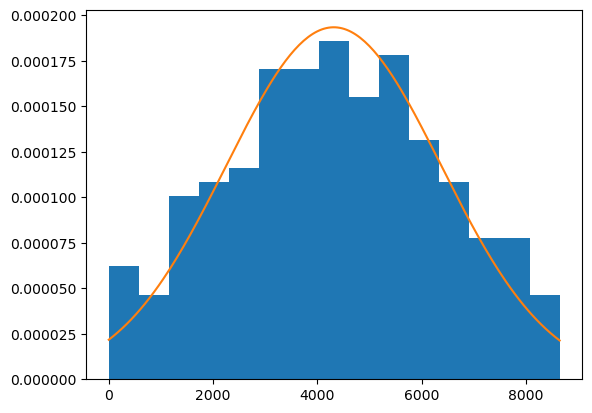

In [57]:
#departures
city_sum_1h_d = multi_zone_1h_d.select(pl.col('event_time_bucket'),
                                   pl.sum_horizontal(pl.all().exclude('event_time_bucket')).alias('total_sum'))
city_sum_reordered_d = city_sum_1h_d.with_columns(pl.col('event_time_bucket').dt.date().alias('date'),
                                              pl.col('event_time_bucket').dt.time().alias('time'),)
columns = ['date']
pivoted_cs_d = city_sum_reordered_d.pivot(
    values='total_sum',
    columns = columns,
    aggregate_function='sum',
    index = 'time'
)
pivoted_cs_sum_d = pivoted_cs_d.select(pl.col('time').alias('event_time_bucket'),
                                     pl.sum_horizontal(pl.all().exclude('time').alias('total_sum')))
# print(pivoted_cs_sum)

peak_hours_d = rush_off_bound(pivoted_cs_sum_d,
                            threshold = 0.70,
                            condition= 'hour',
                            check_var = 'rush',
                            bound = 'markov',
                            dist_var = 'none')
print(peak_hours_d)
city_sum_reordered_d = city_sum_reordered_d.with_columns(pl.col('event_time_bucket').dt.hour().alias('hour'))
city_top30_d = city_sum_reordered_d.filter(pl.col('hour').is_in(peak_hours_d['total_sum'])).sort('hour')

print(city_top30_d)
print(city_top30_d['total_sum'].to_list())
data_l1_d = np.array(city_top30_d['total_sum'].to_list())
data_l1_mean_d = np.mean(data_l1_d)
data_l1_std_d = np.std(data_l1_d)
print(data_l1_mean_d)
print(data_l1_std_d**2)

plt.hist(data_l1_d, bins=15, density=True)
xs_d = np.linspace(min(data_l1_d), max(data_l1_d), 200)
plt.plot(xs_d, norm.pdf(xs_d, loc=data_l1_mean_d, scale=data_l1_std_d))


Final Bin values: 44


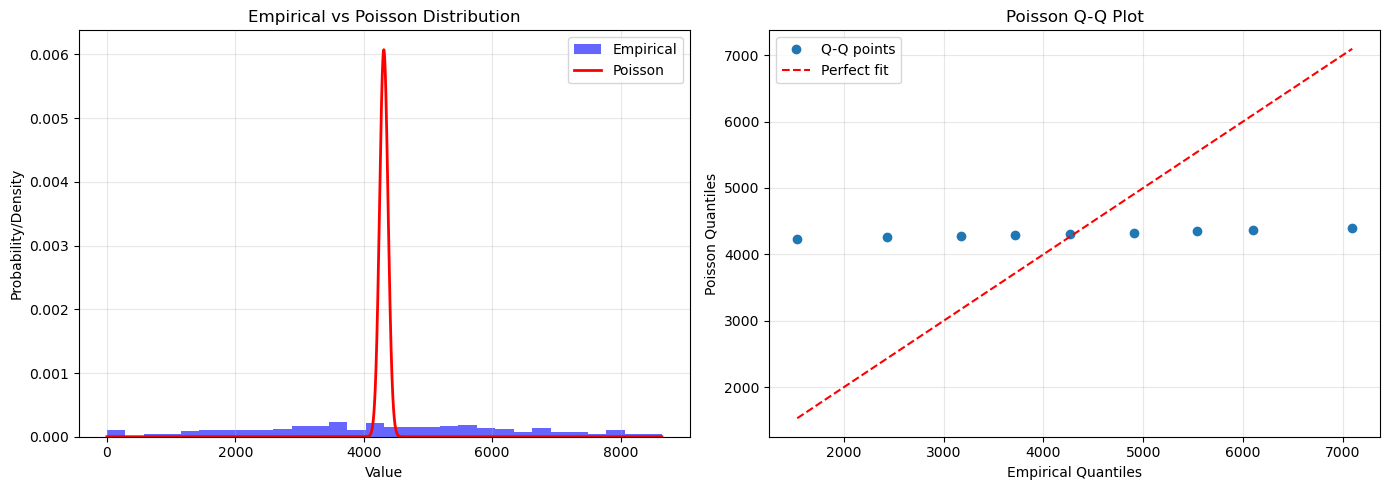

{'chi_score': np.float64(inf), 'dispersion': np.float64(990.328701952493), 'emp_quantile': array([1532.2, 2435.6, 3170.5, 3717. , 4267.5, 4907.2, 5540.8, 6100.8,
       7095.3]), 'poisson_quantile': [np.float64(4228.0), np.float64(4257.0), np.float64(4278.0), np.float64(4296.0), np.float64(4312.0), np.float64(4329.0), np.float64(4347.0), np.float64(4368.0), np.float64(4397.0)], 'p_value': np.float64(0.0)}


In [58]:
poi_dict_d = poisson_check(data_l1_d)
print(poi_dict_d)

Final Bin values (NB): 44


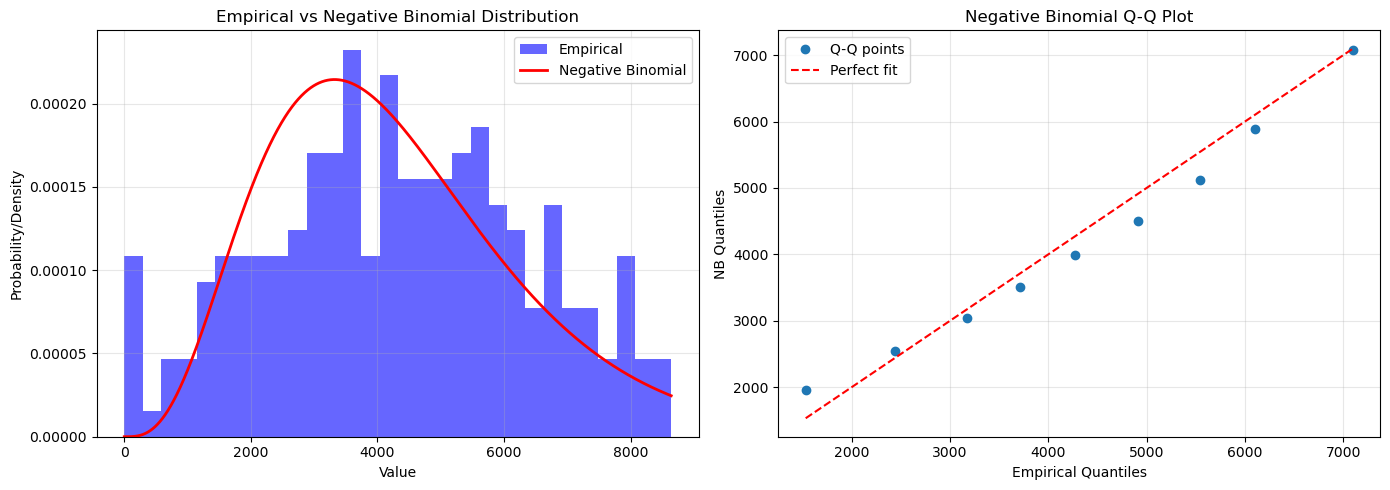

{'chi_score': np.float64(11835.98651533045), 'dispersion': np.float64(990.328701952493), 'emp_quantile': array([1532.2, 2435.6, 3170.5, 3717. , 4267.5, 4907.2, 5540.8, 6100.8,
       7095.3]), 'nb_quantile': [np.float64(1965.0), np.float64(2550.0), np.float64(3041.0), np.float64(3508.0), np.float64(3987.0), np.float64(4509.0), np.float64(5114.0), np.float64(5888.0), np.float64(7081.0)], 'n_param': np.float64(4.358998313044218), 'p_param': np.float64(0.0010097657454827265), 'p_value': np.float64(0.0)}


In [59]:
nb_dict_d = nb_check(data_l1_d)
print(nb_dict_d)

# Off Hours data modelling (Top 30%)
## Arrivals and Departures from stations
### Data aggregated over all the stations

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 16   ┆ 140705    │
│ 23   ┆ 34301     │
│ 6    ┆ 38804     │
│ 9    ┆ 118320    │
│ 13   ┆ 105815    │
│ …    ┆ …         │
│ 11   ┆ 89760     │
│ 12   ┆ 100200    │
│ 7    ┆ 80735     │
│ 5    ┆ 13872     │
│ 4    ┆ 5854      │
└──────┴───────────┘
{'total_sum': [16, 9, 13, 22, 14, 21, 20, 15, 18, 10, 8, 19, 17, 11, 12, 7]}
shape: (496, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-05 07:00:00 ┆ 3336      ┆ 2024-01-05 ┆ 07:00:00 ┆ 7    │
│ 2024-01-09 07:00:00 ┆ 4609      ┆ 2024-01-09 ┆ 07:00:00 ┆ 7    │
│ 2024-01-10 07:00:00 ┆ 4440      ┆ 2024-01-10 ┆ 07:00:00 ┆ 7    │

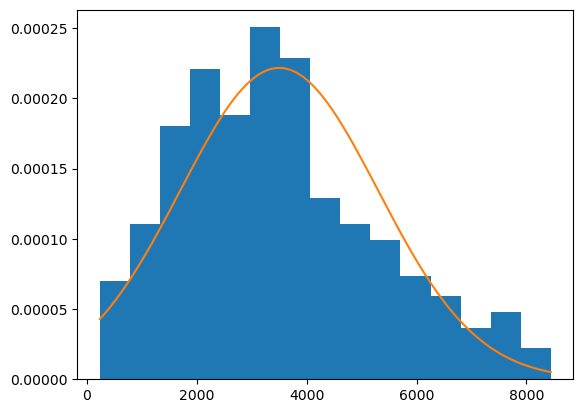

In [60]:
#arrivals
off_hours_a = rush_off_bound(pivoted_cs_sum_a,
                            threshold = 0.30,
                            condition= 'hour',
                            check_var = 'off',
                            bound = 'markov',
                            dist_var = 'none')
print(off_hours_a)

city_bottom30_a = city_sum_reordered_a.filter(pl.col('hour').is_in(off_hours_a['total_sum'])).sort('hour')

print(city_bottom30_a)
print(city_bottom30_a['total_sum'].to_list())
data_l2_a = np.array(city_bottom30_a['total_sum'].to_list())
data_l2_mean_a = np.mean(data_l2_a)
data_l2_std_a = np.std(data_l2_a)
print(data_l2_mean_a)
print(data_l2_std_a**2)

plt.hist(data_l2_a, bins=15, density=True)
xs_a = np.linspace(min(data_l2_a), max(data_l2_a), 200)
plt.plot(xs_a, norm.pdf(xs_a, loc=data_l2_mean_a, scale=data_l2_std_a))


Final Bin values: 50


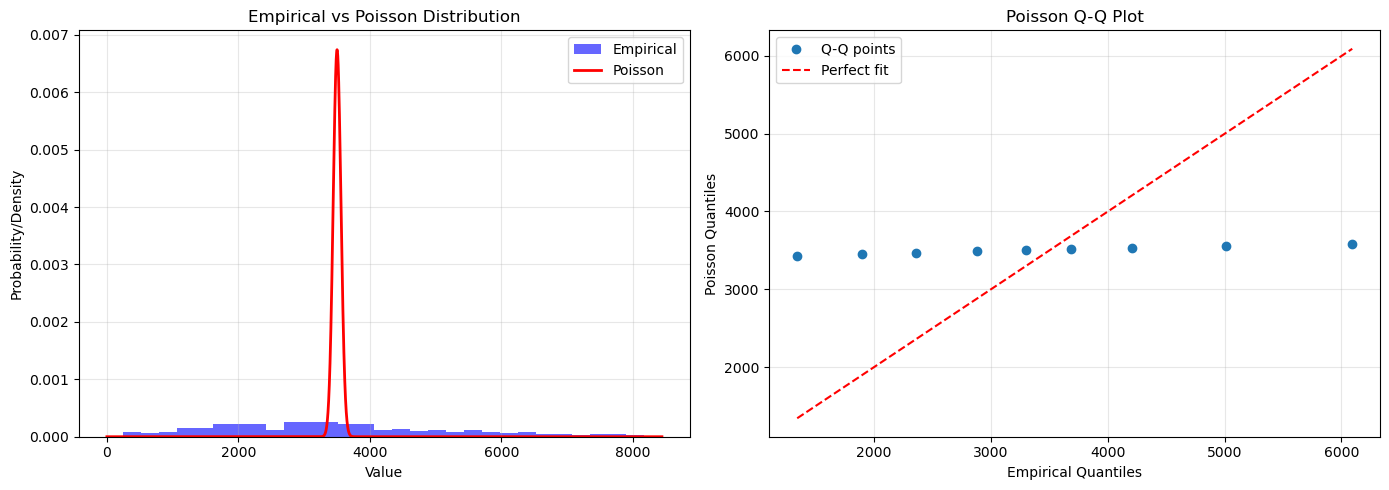

{'chi_score': np.float64(inf), 'dispersion': np.float64(926.2227493718308), 'emp_quantile': array([1341.5, 1899. , 2362. , 2881. , 3298.5, 3688. , 4209.5, 5012. ,
       6092. ]), 'poisson_quantile': [np.float64(3426.0), np.float64(3452.0), np.float64(3471.0), np.float64(3487.0), np.float64(3502.0), np.float64(3517.0), np.float64(3533.0), np.float64(3551.0), np.float64(3578.0)], 'p_value': np.float64(0.0)}


In [61]:
poi_dict_a_off = poisson_check(data_l2_a)
print(poi_dict_a_off)

Final Bin values (NB): 50


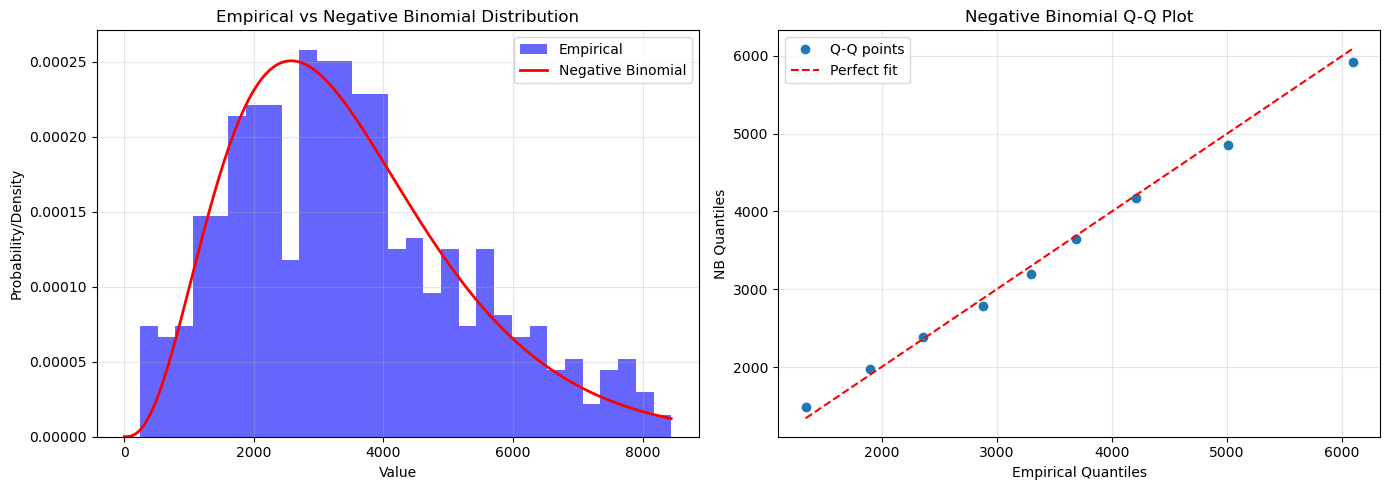

{'chi_score': np.float64(73.23706881378435), 'dispersion': np.float64(926.2227493718308), 'emp_quantile': array([1341.5, 1899. , 2362. , 2881. , 3298.5, 3688. , 4209.5, 5012. ,
       6092. ]), 'nb_quantile': [np.float64(1481.0), np.float64(1970.0), np.float64(2385.0), np.float64(2785.0), np.float64(3198.0), np.float64(3651.0), np.float64(4180.0), np.float64(4860.0), np.float64(5916.0)], 'n_param': np.float64(3.7847250427584784), 'p_param': np.float64(0.0010796538960829943), 'p_value': np.float64(0.008476348815979926)}


In [62]:
nb_dict_a_off = nb_check(data_l2_a)
print(nb_dict_a_off)

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 11   ┆ 91840     │
│ 1    ┆ 13311     │
│ 14   ┆ 120394    │
│ 4    ┆ 6027      │
│ 2    ┆ 8902      │
│ …    ┆ …         │
│ 12   ┆ 101578    │
│ 19   ┆ 110130    │
│ 7    ┆ 91285     │
│ 3    ┆ 5907      │
│ 10   ┆ 88597     │
└──────┴───────────┘
{'total_sum': [11, 14, 22, 13, 21, 15, 18, 8, 20, 17, 16, 9, 12, 19, 7, 10]}
shape: (511, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-31 07:00:00 ┆ 4935      ┆ 2024-01-31 ┆ 07:00:00 ┆ 7    │
│ 2024-01-18 07:00:00 ┆ 3202      ┆ 2024-01-18 ┆ 07:00:00 ┆ 7    │
│ 2024-01-25 07:00:00 ┆ 2922      ┆ 2024-01-25 ┆ 07:00:00 ┆ 7    │

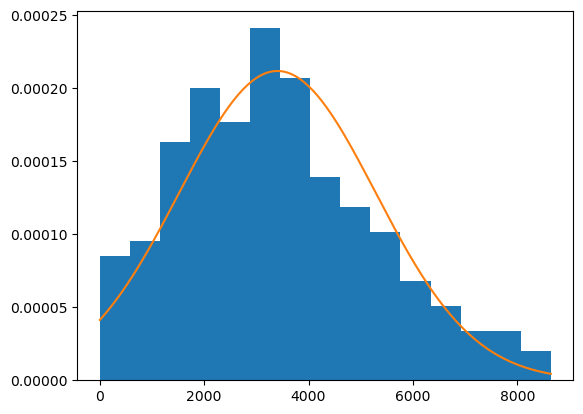

In [63]:
#departures
off_hours_d = rush_off_bound(pivoted_cs_sum_d,
                            threshold = 0.30,
                            condition= 'hour',
                            check_var = 'off',
                            bound = 'markov',
                            dist_var = 'none')
print(off_hours_d)

city_bottom30_d = city_sum_reordered_d.filter(pl.col('hour').is_in(off_hours_d['total_sum'])).sort('hour')

print(city_bottom30_d)
print(city_bottom30_d['total_sum'].to_list())
data_l2_d = np.array(city_bottom30_d['total_sum'].to_list())
data_l2_mean_d = np.mean(data_l2_d)
data_l2_std_d = np.std(data_l2_d)
print(data_l2_mean_d)
print(data_l2_std_d**2)

plt.hist(data_l2_d, bins=15, density=True)
xs_d = np.linspace(min(data_l2_d), max(data_l2_d), 200)
plt.plot(xs_d, norm.pdf(xs_d, loc=data_l2_mean_d, scale=data_l2_std_d))


Final Bin values: 50


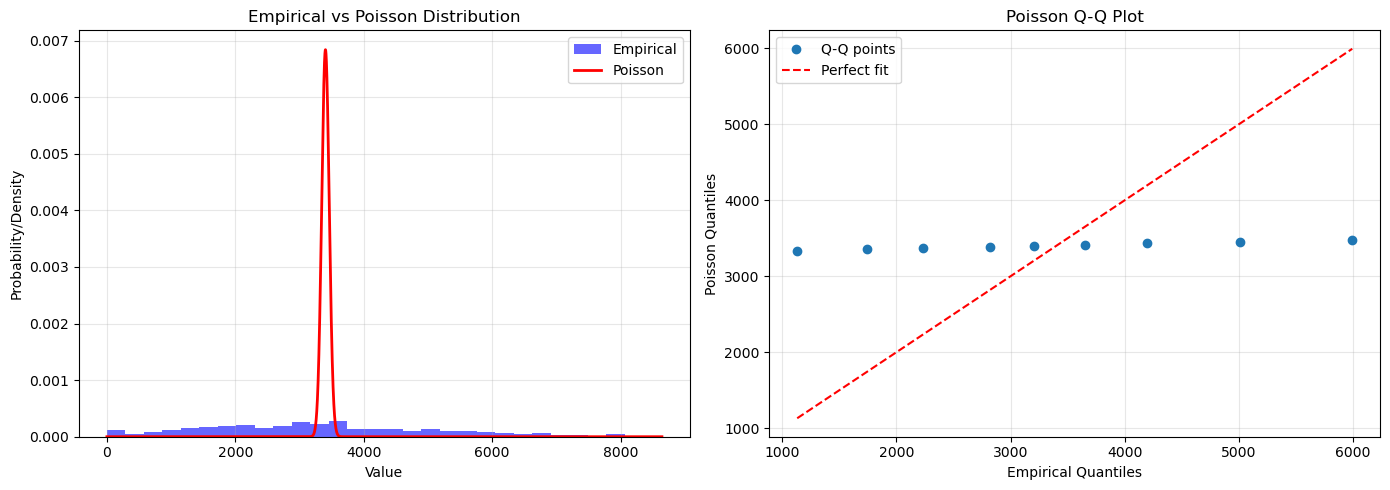

{'chi_score': np.float64(inf), 'dispersion': np.float64(1043.342017071646), 'emp_quantile': array([1132., 1744., 2236., 2823., 3207., 3650., 4196., 5013., 5993.]), 'poisson_quantile': [np.float64(3329.0), np.float64(3355.0), np.float64(3373.0), np.float64(3389.0), np.float64(3404.0), np.float64(3418.0), np.float64(3434.0), np.float64(3453.0), np.float64(3479.0)], 'p_value': np.float64(0.0)}


In [64]:
poi_dict_d_off = poisson_check(data_l2_d)
print(poi_dict_d_off)

Final Bin values (NB): 50


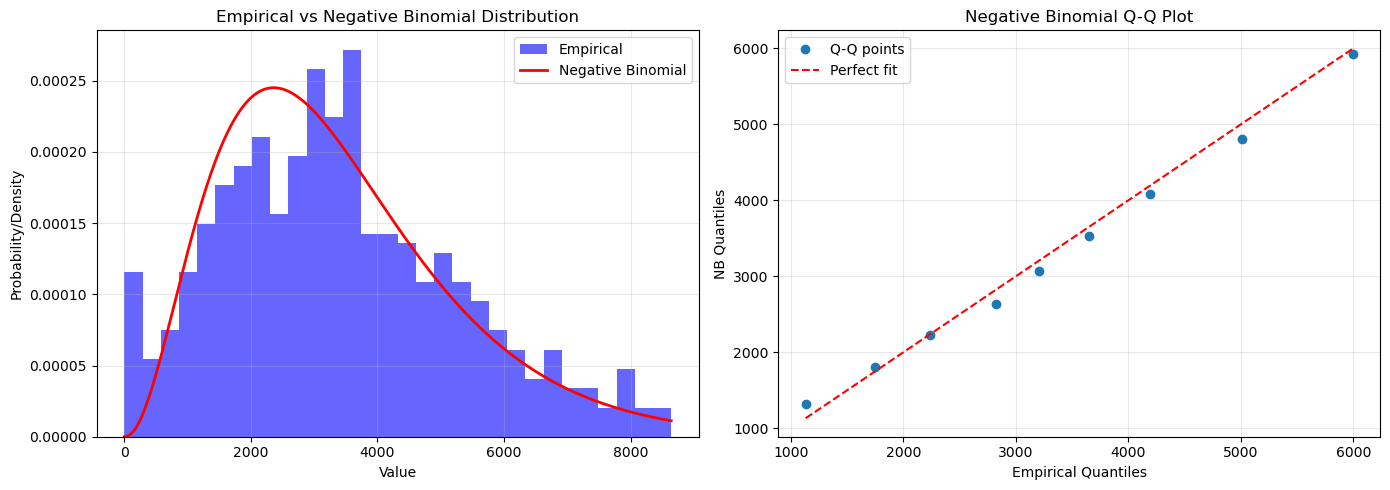

{'chi_score': np.float64(1478.3993913931101), 'dispersion': np.float64(1043.342017071646), 'emp_quantile': array([1132., 1744., 2236., 2823., 3207., 3650., 4196., 5013., 5993.]), 'nb_quantile': [np.float64(1320.0), np.float64(1806.0), np.float64(2227.0), np.float64(2636.0), np.float64(3063.0), np.float64(3534.0), np.float64(4089.0), np.float64(4807.0), np.float64(5931.0)], 'n_param': np.float64(3.265473012006038), 'p_param': np.float64(0.0009584584763553428), 'p_value': np.float64(6.323046302692549e-279)}


In [65]:
nb_dict_d_off = nb_check(data_l2_d)
print(nb_dict_d_off)